In [38]:
#%pip install scikeras
#%pip install spectral
#%pip install --upgrade matplotlib 
#%pip install scikit-optimize
#%pip install --upgrade tensorflow
#%pip install --upgrade keras
#%pip install tqdm
#%pip install -U tensorflow-addons
#%pip install lazypredict
#%pip install seaborn


In [39]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [1]:
#%pip install msvc-runtime

import os
from spectral import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import tensorflow as tf
#from tensorflow.keras.layers import Dropout, Dense, Input, Lambda
#import scikeras
import scipy
# import keras
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from scipy.stats import reciprocal
# from sklearn.metrics import accuracy_score
# # hyperparameter optimization methods
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_objective, plot_histogram, plot_evaluations
# from skopt.callbacks import CheckpointSaver
# #import optuna
# #from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# #import hyperopt
import pickle
import pandas as pd
#import skopt
from sklearn.model_selection import train_test_split, cross_val_score
#import tqdm # nice progress bar
from scipy.signal import find_peaks

print(f'Numpy Version: {np. __version__}')
print(f'TensorFlow Version: {tf. __version__}')
#print(f'Keras Version: {keras. __version__}')

# NOTE:  The 'from lazypredict.Supervised import LazyClassifier' gives this error:
# TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'
# to fix this, go into sklearn and switch
#    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#  to
#    OH_encoder = OneHotEncoder(handle_unknown='ignore')


2025-01-28 18:46:54.519916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 18:46:54.985826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 18:46:55.136043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 18:46:55.189545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 18:46:55.468790: I tensorflow/core/platform/cpu_feature_guar

Numpy Version: 1.26.4
TensorFlow Version: 2.17.0


# Load the UPWINS spectral library and metadata csv

In [41]:
# # Load the quality-checked spectra and metadata from numpy variables
# spectra = np.load('data/spectra.npy')
# wl = np.load('data/wl.npy')
# genus = np.load('data/genus.npy')
# species = np.load('data/species.npy')
# principle_part = np.load('data/principle_part.npy')
# health = np.load('data/health.npy')
# growth_stage = np.load('data/growth_stage.npy')
# DateTimeId = np.load('data/DateTimeId.npy')
# month = np.load('data/month.npy')
# name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
# name_genus_species = np.load('data/name_genus_species.npy')# the genus and species if known - otherwise NA
# name_full_category = np.load('data/name_full_category.npy')# all the metadata available in one string
# plant_type = np.load('data/plant_type.npy')# the type of plant (tree, shrub, grass, etc.) - otherwise NA

# nSpec = spectra.shape[0]
# nBands = spectra.shape[1]
# print(f'Min wavelength: {np.min(wl)}')
# print(f'Max wavelength: {np.max(wl)}')
# print(f'Number of Spectra: {nSpec}')
# print(f'Number of Bands: {nBands}')

## New: Load full spectral library

In [2]:
import sys
sys.path.append('util/')
import importlib

import util_scripts as util

import os
from dotenv import load_dotenv

from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

MONGO_DBR_URI = os.getenv('MONGO_DBR_URI')

In [3]:
importlib.reload(util)

<module 'util_scripts' from '/workspaces/NN_Hyperspectral_Vegetation/util/util_scripts.py'>

In [ ]:
reload_data_driver = False

if (reload_data_driver):

    records = []

    # Create a new client and connect to the server
    client = MongoClient(MONGO_DBR_URI, server_api=ServerApi('1'))

    # Send a ping to confirm a successful connection
    try:
        client.admin.command('ping')
        print("Pinged your deployment. You successfully connected to MongoDB!")
    except Exception as e:
        print(e)

    db = client["upwins_db"]
    view_name = "spectral_library"
    spectral_library = db[view_name]

    records = spectral_library.find()

    df = pd.DataFrame(records)
    df.to_pickle('util/data/data.pkl')

else:
    df = pd.read_pickle('util/data/data.pkl')

Pinged your deployment. You successfully connected to MongoDB!


In [5]:
sc = util.SpectralCollection(df)
wl = sc.wl
name = sc.name
spectra = sc.spectra

# Prepare the data for training and testing

In [6]:
# Assemble X and Y for training
X_o = sc.spectra
Yn_o = sc.name
Yg_o = sc.genus
Ys_o = sc.species
Ypp_o = sc.principle_part
Yh_o = sc.health
Ya_o = sc.age
Yb_o = sc.bloom
Yd_o = sc.DateTimeId
Ym_o = sc.month
Yngs_o = sc.name_genus_species
Ynfc_o = sc.name_full_category
Ypt_o = sc.plant_type
print(X_o.shape,Yn_o.shape)
print(f'Number of genus: {len(np.unique(Yg_o))}: {np.unique(Yg_o)}\n')
print(f'Number of species: {len(np.unique(Ys_o))}: {np.unique(Ys_o)}\n')
print(f'Number of principle_parts: {len(np.unique(Ypp_o))}: {np.unique(Ypp_o)}\n')
print(f'Number of health categories: {len(np.unique(Yh_o))}: {np.unique(Yh_o)}\n')
print(f'Number of age categories: {len(np.unique(Ya_o))}: {np.unique(Ya_o)}\n')
print(f'Number of bloom categories: {len(np.unique(Yb_o))}: {np.unique(Yb_o)}\n')
print(f'Number of Date-Time_Id values: {len(np.unique(Yd_o))}\n')
print(f'Number of months: {len(np.unique(Ym_o))}: {np.unique(Ym_o)}\n')
print(f'Number of names: {len(np.unique(Yn_o))}: {np.unique(Yn_o)}\n')
print(f'Number of name_genus_species categories: {len(np.unique(Yngs_o))}: {np.unique(Yngs_o)}\n')
print(f'Number of name_full_categories: {len(np.unique(Ynfc_o))}\n')
print(f'Number of plant types: {len(np.unique(Ypt_o))}: {np.unique(Ypt_o)}\n')

(3459, 2151) (3459,)
Number of genus: 11: ['Ammophila' 'Baccharis' 'Chamaecrista' 'Chasmanthium' 'Ilex' 'Iva'
 'Morella' 'Panicum' 'Robinia' 'Rosa' 'Solidago']

Number of species: 12: ['amarum' 'breviligulata' 'fasciculata' 'frutescens' 'halimifolia'
 'hispida' 'latifolium' 'pennsylvanica' 'rugosa' 'sempervirens' 'virgatum'
 'vomitoria']

Number of principle_parts: 9: ['FL' 'FR' 'L' 'LG' 'MX' 'N' 'SE' 'SP' 'ST']

Number of health categories: 9: ['DS' 'H' 'LLRZ' 'MH' 'N' 'R' 'S' 'SS' 'SY']

Number of age categories: 7: ['1G' 'D' 'J' 'M' 'N' 'PE' 'RE']

Number of bloom categories: 4: ['FFG' 'FLG' 'FRG' 'N']

Number of Date-Time_Id values: 3459

Number of months: 10: ['01' '02' '03' '06' '07' '08' '09' '10' '11' '12']

Number of names: 13: ['Ammophila_breviligulata' 'Baccharis_halimifolia'
 'Chamaecrista_fasciculata' 'Chasmanthium_latifolium' 'Ilex_vomitoria'
 'Iva_frutescens' 'Morella_pennsylvanica' 'Panicum_amarum'
 'Panicum_virgatum' 'Robinia_hispida' 'Rosa_rugosa' 'Solidago_rugosa'
 '

## Analysis of Baccharis_halimifolia vs Ilex_vomitoria

In [7]:
species_1 = 'Baccharis_halimifolia'
species_2 = 'Ilex_vomitoria'

prediction_class = 'name'

# compute the indices for these species
idx_1 = np.where(Yn_o==species_1)[0]
idx_2 = np.where(Yn_o==species_2)[0]
idx = np.concatenate((idx_1, idx_2))

nSpec = len(idx)

## Analysis: Same part of same plant over time (predict age)

In [7]:
filter = {
    'name': 'Chasmanthium_latifolium',
    #'fname': '',
    #'genus': '',
    #'species': '',
    #'age': '',
    'health': 'H',
    'part': 'L',
    #'type': '',
    #'bloom': '',
    #'date': ''
}

prediction_class = 'age'

idx = sc.select_indicies_with_filter(filter)

nSpec = len(idx)
nSpec

107

## Anaysis: Different parts of the same plant (predict part)

In [7]:
filter = {
    'name': 'Panicum_virgatum',
    #'fname': '',
    #'genus': '',
    #'species': '',
    'age': 'J',
    'health': 'H',
    #'part': '',
    #'type': '',
    #'bloom': '',
    #'date': ''
}

prediction_class = 'part'

idx = sc.select_indicies_with_filter(filter)

nSpec = len(idx)
nSpec

108

## Assemble data

In [8]:
# Assemble X and Y for training
X = sc.spectra[idx]
Yn = sc.name[idx]
Yg = sc.genus[idx]
Ys = sc.species[idx]
Ypp = sc.principle_part[idx]
Yh = sc.health[idx]
Ya = sc.age[idx]
Yb = sc.bloom[idx]
Yd = sc.DateTimeId[idx]
Ym = sc.month[idx]
Yngs = sc.name_genus_species[idx]
Ynfc = sc.name_full_category[idx]
Ypt = sc.plant_type[idx]
print(X.shape,Yn.shape)


(108, 2151) (108,)


In [9]:
prediction_class_dict = {
    'name': Yn,
    'genus': Yg,
    'species': Ys,
    'age': Ya,
    'health': Yh,
    'part': Ypp,
    'type': Ypt,
    'bloom': Yb,
    'date': Yd
}

In [10]:
Y_type = prediction_class_dict[prediction_class]
print(Y_type)
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]
print(f'Categories for classification: {Y}')
nClasses =len(Y_labels)
print(f'Number of classes: {nClasses}')

['L' 'N' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'MX' 'MX' 'MX' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'FL' 'FL' 'FL' 'FL' 'FL'
 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL'
 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL'
 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL' 'FL'
 'FL' 'FL' 'FL' 'FL' 'SE' 'SE' 'SE' 'SE' 'SE' 'SE' 'SE' 'SE' 'SE' 'L' 'L'
 'L' 'L' 'L' 'L' 'L' 'L' 'MX' 'MX' 'MX' 'MX' 'MX' 'MX' 'MX' 'MX' 'MX' 'MX'
 'MX']
Categories for classification: [1 3 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
Number of classes: 5


## Test-train split

In [11]:
# Create a test-train split
X_train80, X_test, Y_train80, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train80, Y_train80, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

(64, 2151) 0.5925925925925926
(22, 2151) 0.2037037037037037
(22, 2151) 0.2037037037037037


In [99]:
# Classification results using lazy classifier
rerun_LazyClassifier = True
if rerun_LazyClassifier:
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train80, X_test, Y_train80, Y_test)
    models.to_csv(f'output/LazyClassifier_results_2_categories.csv')
else:
    models = pd.read_csv('output/LazyClassifier_results_2_categories.csv')
models

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [00:27<00:00,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65238
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 2151
[LightGBM] [Info] Start training from score -0.765468
[LightGBM] [Info] Start training from score -1.087051
[LightGBM] [Info] Start training from score -2.151762
[LightGBM] [Info] Start training from score -4.454347
[LightGBM] [Info] Start training from score -2.662588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 29/29 [00:28<00:00,  1.04it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                        
LGBMClassifier                   0.86               0.81    None      0.84   
LinearSVC                        0.86               0.81    None      0.84   
SVC                              0.86               0.81    None      0.84   
CalibratedClassifierCV           0.86               0.81    None      0.84   
RidgeClassifierCV                0.86               0.81    None      0.84   
RandomForestClassifier           0.86               0.81    None      0.84   
ExtraTreesClassifier             0.86               0.81    None      0.84   
LogisticRegression               0.86               0.81    None      0.84   
KNeighborsClassifier             0.86               0.81    None      0.84   
PassiveAggressiveClassifier      0.77               0.77    None      0.77   
LinearDiscriminantAnalysis       0.77               0.77    None      0.78   
DecisionTreeClassifier           0.82               0.75    None      0.81   
XGBClassifier                    0.82               0.75    None      0.81   
RidgeClassifier                  0.73               0.74    None      0.74   
ExtraTreeClassifier              0.77               0.73    None      0.77   
SGDClassifier                    0.77               0.73    None      0.72   
AdaBoostClassifier               0.77               0.73    None      0.72   
GaussianNB                       0.77               0.69    None      0.77   
BaggingClassifier                0.73               0.66    None      0.75   
Perceptron                       0.73               0.66    None      0.68   
NearestCentroid                  0.55               0.57    None      0.62   
BernoulliNB                      0.50               0.55    None      0.59   
LabelSpreading                   0.64               0.44    None      0.56   
LabelPropagation                 0.64               0.44    None      0.56   
DummyClassifier                  0.50               0.25    None      0.33   

                             Time Taken  
Model                                    
LGBMClassifier                     0.78  
LinearSVC                          1.45  
SVC                                0.04  
CalibratedClassifierCV             5.21  
RidgeClassifierCV                  0.09  
RandomForestClassifier             0.25  
ExtraTreesClassifier               0.14  
LogisticRegression                14.42  
KNeighborsClassifier               0.09  
PassiveAggressiveClassifier        0.13  
LinearDiscriminantAnalysis         0.35  
DecisionTreeClassifier             0.09  
XGBClassifier                      2.17  
RidgeClassifier                    0.08  
ExtraTreeClassifier                0.04  
SGDClassifier                      0.09  
AdaBoostClassifier                 1.47  
GaussianNB                         0.05  
BaggingClassifier                  0.38  
Perceptron                         0.06  
NearestCentroid                    0.07  
BernoulliNB                        0.13  
LabelSpreading                     0.09  
LabelPropagation                   0.09  
DummyClassifier                    0.04

# Build an initial NN model

In [12]:
# Model with one hidden layer (128 neurons) with dropout (probability = 0.2), with one final layer.
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01) #<- if we want to control initial weights

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nClasses, activation='softmax')
])

# Comile the layer -> set the optimizer, loss function, and metrics to track.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit (train) the model
history = model.fit(X_train80, Y_train80, epochs=500, batch_size=32);

I0000 00:00:1737744628.004151   32282 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737744628.015511   32282 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737744628.015572   32282 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737744628.020794   32282 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737744628.020889   32282 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/500


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
I0000 00:00:1737744629.531281   33003 service.cc:146] XLA service 0x7f9cac34a2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737744629.531477   33003 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-01-24 18:50:29.550914: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-24 18:50:29.585424: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90600
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recogniz

3/3 [==============================] - 2s 16ms/step - loss: 1.4964 - accuracy: 0.4070
Epoch 2/500


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


3/3 [==============================] - 0s 16ms/step - loss: 1.0341 - accuracy: 0.6512
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 0.9183 - accuracy: 0.6512
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8279 - accuracy: 0.7442
Epoch 5/500
3/3 [==============================] - 0s 18ms/step - loss: 0.7420 - accuracy: 0.8023
Epoch 6/500
3/3 [==============================] - 0s 6ms/step - loss: 0.6224 - accuracy: 0.8023
Epoch 7/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5786 - accuracy: 0.8256
Epoch 8/500
3/3 [==============================] - 0s 7ms/step - loss: 0.5511 - accuracy: 0.8721
Epoch 9/500
3/3 [==============================] - 0s 7ms/step - loss: 0.5102 - accuracy: 0.8256
Epoch 10/500
3/3 [==============================] - 0s 7ms/step - loss: 0.4770 - accuracy: 0.8372
Epoch 11/500
3/3 [==============================] - 0s 6ms/step - loss: 0.4609 - accuracy: 0.8372
Epoch 12/500
3/3 [===================

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Training Data)')
plt.title('Training');
plt.savefig('trainingHistoryAccuracy.png')

In [13]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 1.5315 - accuracy: 0.8636 - 229ms/epoch - 229ms/step

Test accuracy: 0.8636363744735718


In [14]:
predicted = model.predict(X_test)
actual = tf.stack(Y_test, axis=0)
predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

1/1 [==============================] - 0s 92ms/step


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

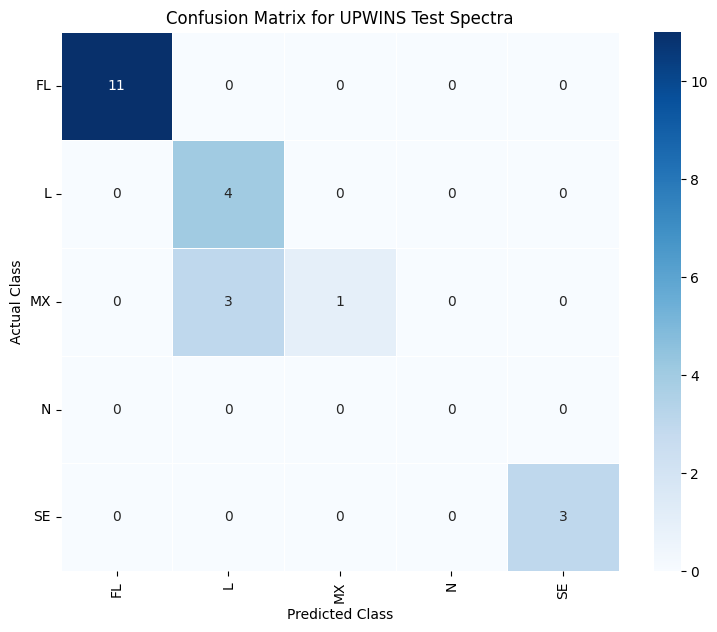

In [15]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = tf.math.confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for UPWINS Test Spectra')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(actual, predicted, Y_labels, 'test')
plt.savefig('confusionMatrix.png')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               275456    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 275843 (1.05 MB)
Trainable params: 275843 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


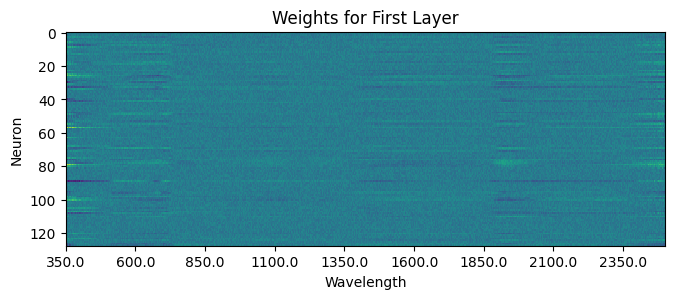

In [16]:
# Visualize the first layer as an image
hidden = model.layers[0]
hidden.name
weights_1, biases_1 = hidden.get_weights()

plt.figure(figsize=(8,3))
plt.imshow(weights_1.T, aspect='6', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for First Layer');
plt.tight_layout()
plt.savefig('output/Layer1WeightsImAll.png')

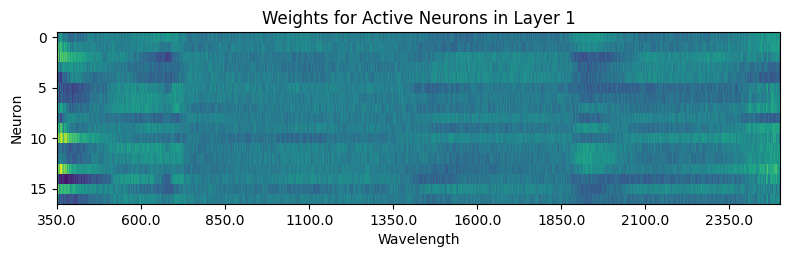

In [17]:
# determine the indices for neurons with structure
indices = np.where(np.std(weights_1, axis=0) > 0.05)[0]
active_weights_1 = weights_1[:,indices].T
active_biases_1 = biases_1[indices]

plt.figure(figsize=(8,3))
plt.imshow(active_weights_1, aspect='30', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for Active Neurons in Layer 1');
plt.tight_layout()
plt.savefig('output/Layer1WeightsIm.png')

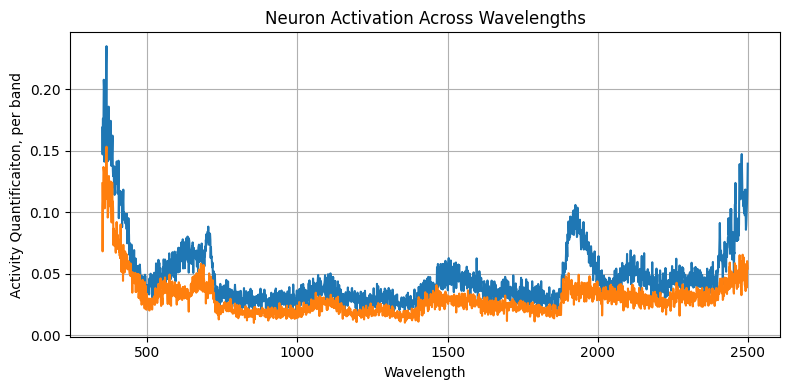

In [18]:
activity = np.mean(np.abs(active_weights_1),axis=0)
activity_var = np.std(np.abs(active_weights_1),axis=0)

plt.figure(figsize=(8,4))
plt.plot(wl,activity, label='Mean Absulte Value of Weight')
plt.plot(wl,activity_var, label='Standard deviation in Weight')
plt.xlabel('Wavelength')
plt.ylabel('Activity Quantificaiton, per band')
plt.title('Neuron Activation Across Wavelengths')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/NeuronActivityPerWL.png')

In [ ]:
# plot the weights for each active weight in the first layer
rows = int(np.ceil(len(indices)/4))

fig = plt.figure(figsize=(25,15))
for i in range(len(indices)):
    fig.add_subplot(rows,4,i+1)
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer1NeuronWeights.png')

In [ ]:
# plot the weights for each active weight in the first layer
for i in range(len(indices)):
    plt.figure(figsize=(5,3))
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
    plt.tight_layout()
    plt.savefig('output/Layer1NeuronWeights_'+str(i)+'.png')

In [ ]:
# plot activations for one active neruon and one inactive neuron
i_inact = 1
i_act = 4
fig = plt.figure(figsize=(5,5))

fig.add_subplot(2,1,1)
plt.plot(wl,weights_1[:,i_inact])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Inactive Neuron');

fig.add_subplot(2,1,2)
plt.plot(wl,weights_1[:,i_act])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');

plt.tight_layout()
plt.savefig('output/activeAndInactiveNeurons.png')

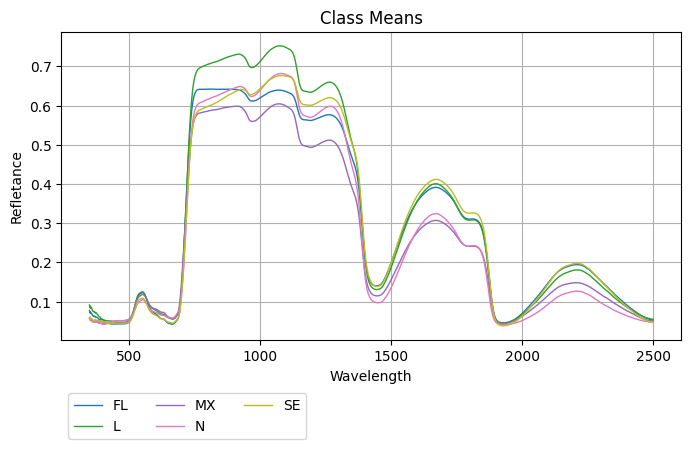

In [19]:
cmap = matplotlib.colormaps.get_cmap("tab10")

# plot the mean of each class
plt.figure(figsize=(8,4))
plt.grid(True)
for i, n in enumerate(np.unique(Y_type)):
    idx = np.where(Y_type==n)[0]
    mean_spectrum = np.mean(sc.spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, c=cmap(i/len(Y_labels)), lw=1)
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means')
plt.legend(bbox_to_anchor=(0.0, -0.15), ncols=3, loc='upper left');
plt.savefig('output/meanSpectra.png')

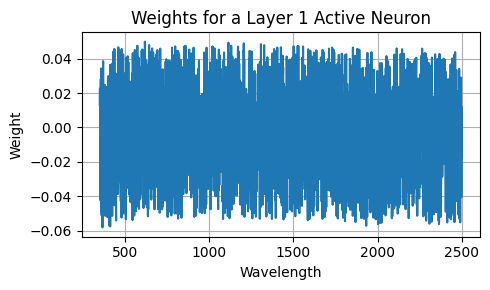

In [64]:
i=4
plt.figure(figsize=(5,3))
plt.plot(wl,weights_1[:,i])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');
plt.tight_layout()
plt.savefig('output/activeNeuron.png')

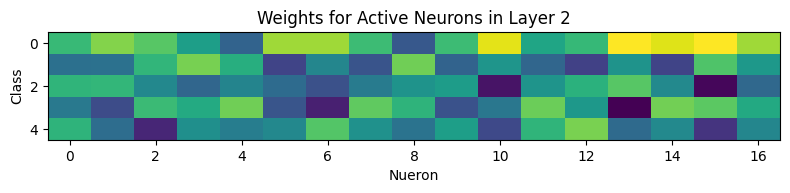

In [20]:
# Visualize the second layer as an image
hidden = model.layers[1]
hidden.name
weights_2, biases_2 = hidden.get_weights()
active_weights_2 = weights_2[indices,:].T

plt.figure(figsize=(8,4))
plt.imshow(active_weights_2, aspect='0.5', interpolation='none');
plt.xlabel('Nueron');
plt.ylabel('Class');
plt.title('Weights for Active Neurons in Layer 2');
plt.tight_layout()
plt.savefig('output/Layer2WeightsIm.png')

In [ ]:
fig = plt.figure(figsize=(25,18))
for i in range(nClasses):
    fig.add_subplot(5,4,i+1)
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for {Y_labels[i]}, bias={str(round(biases_2[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer2ClassWeights.png')

In [ ]:
# plot the weights for each active weight in the first layer
for i in range(nClasses):
    plt.figure(figsize=(5,3))
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Layer 2 Weights for {Y_labels[i]}')
    plt.tight_layout()
    plt.savefig('output/Layer2ClassWeights_'+Y_labels[i]+'.png')

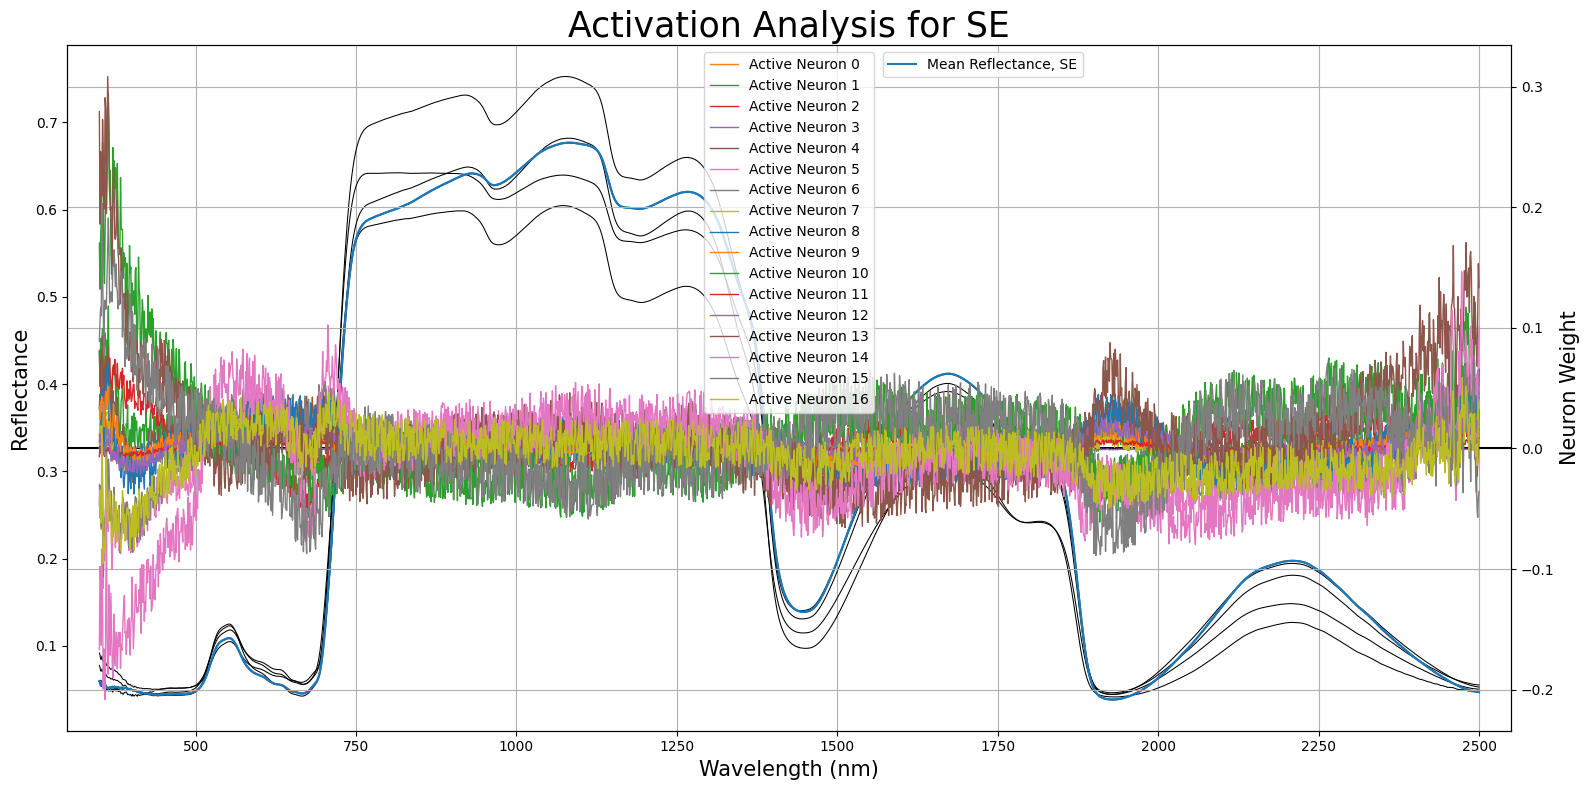

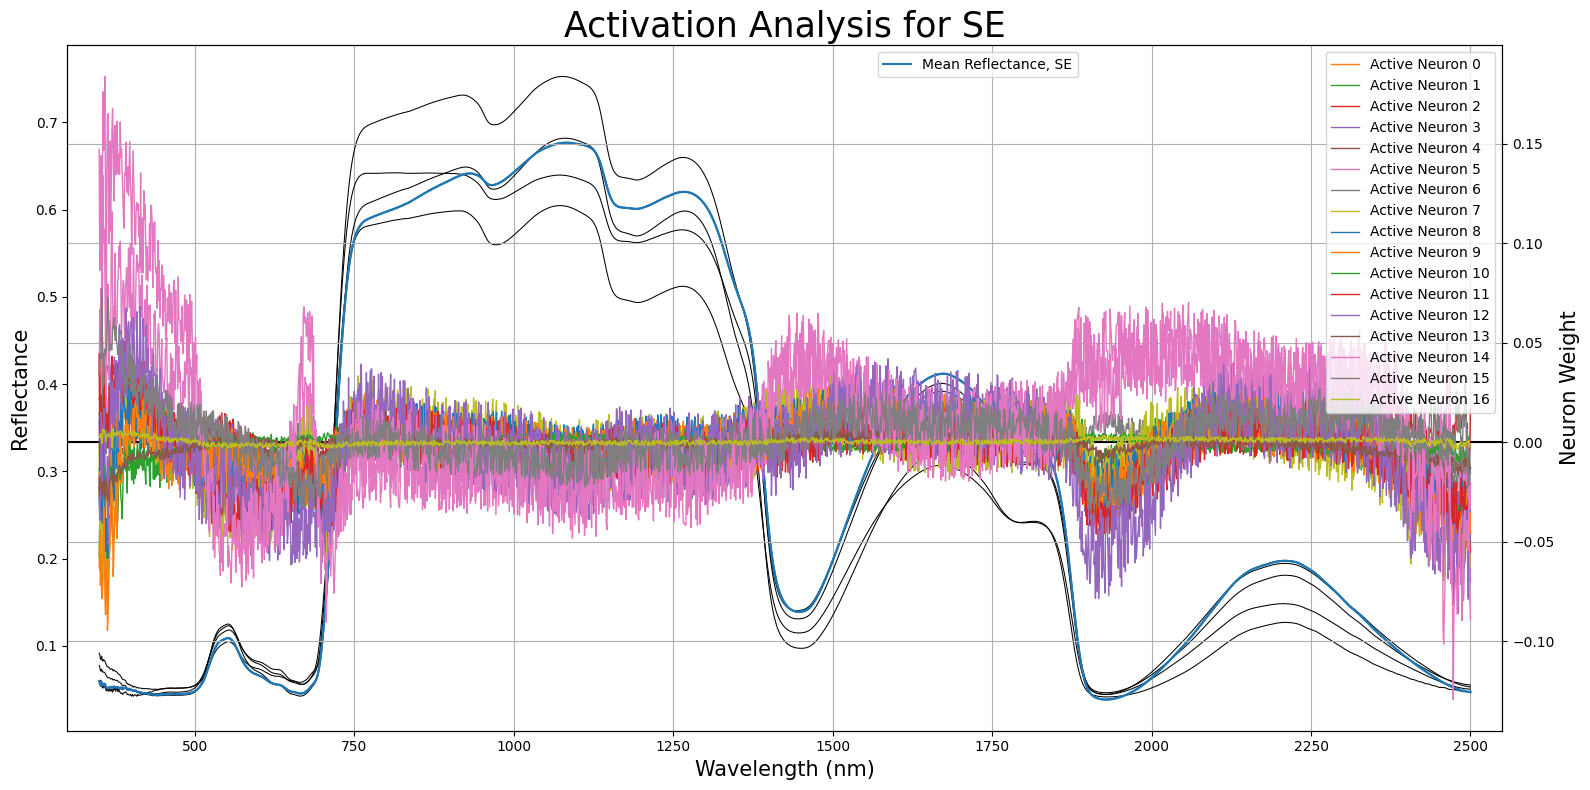

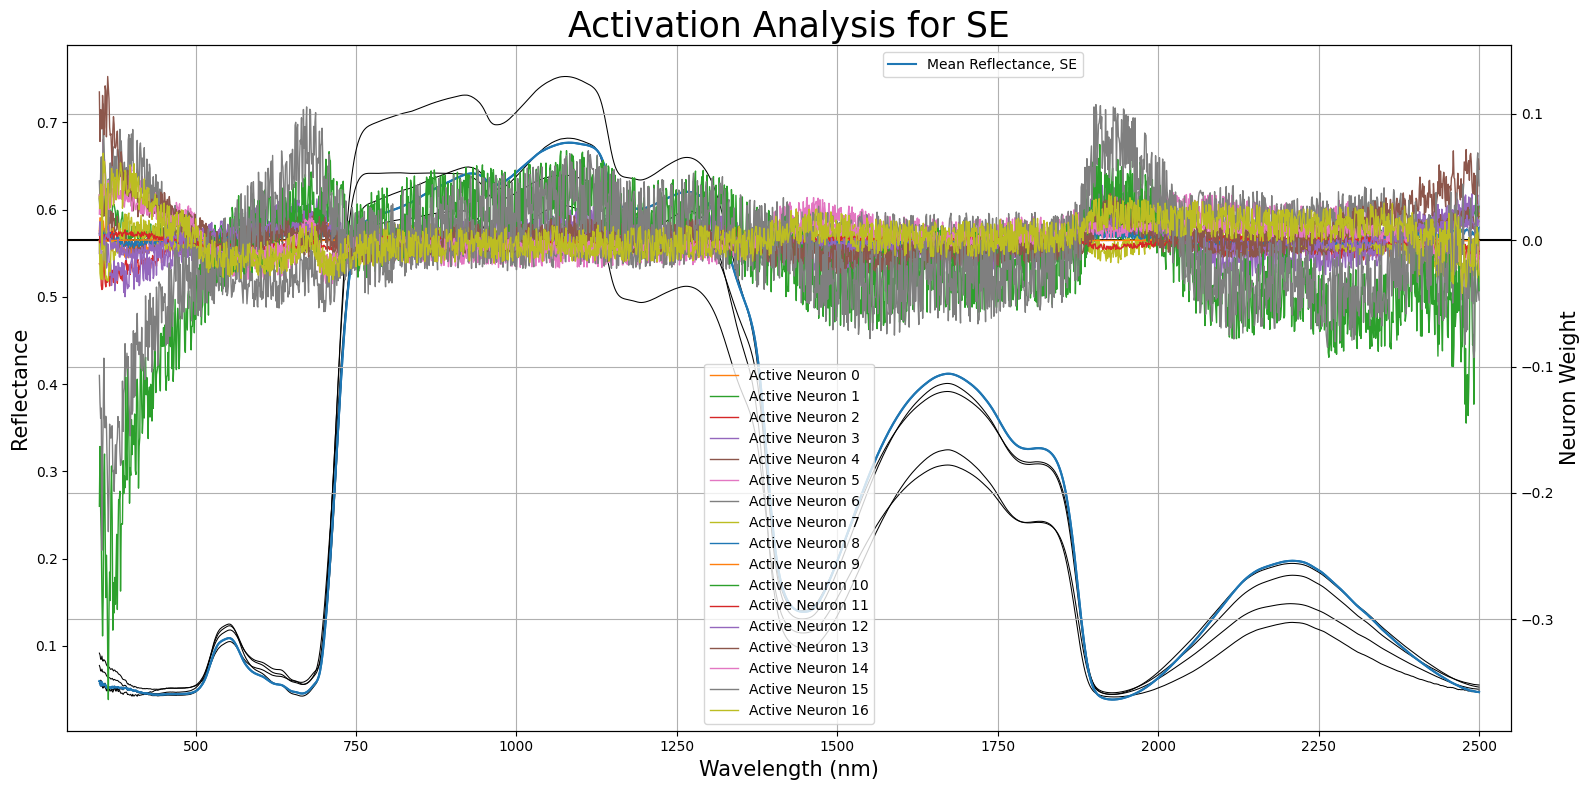

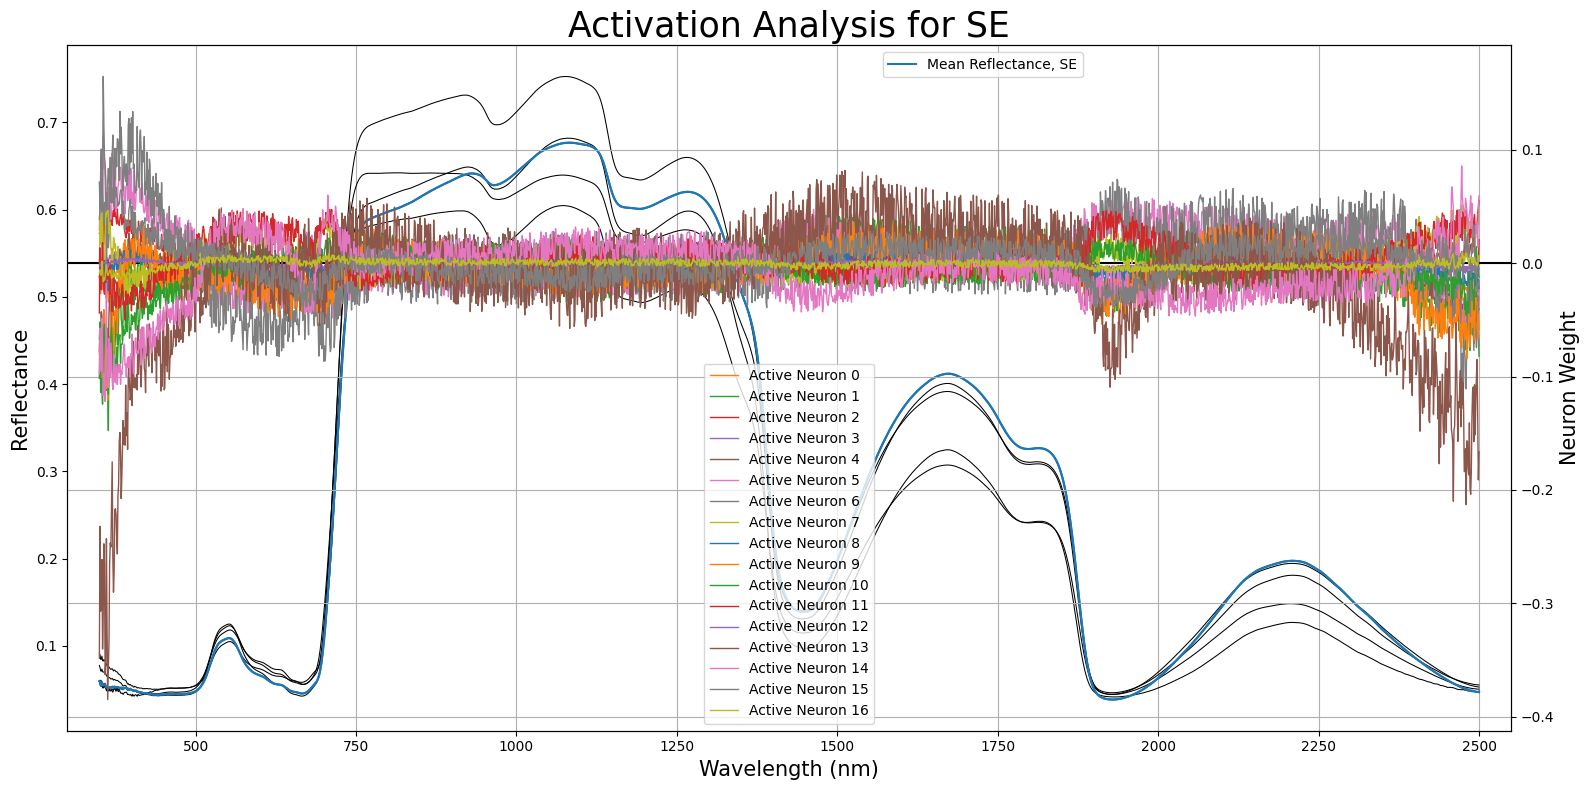

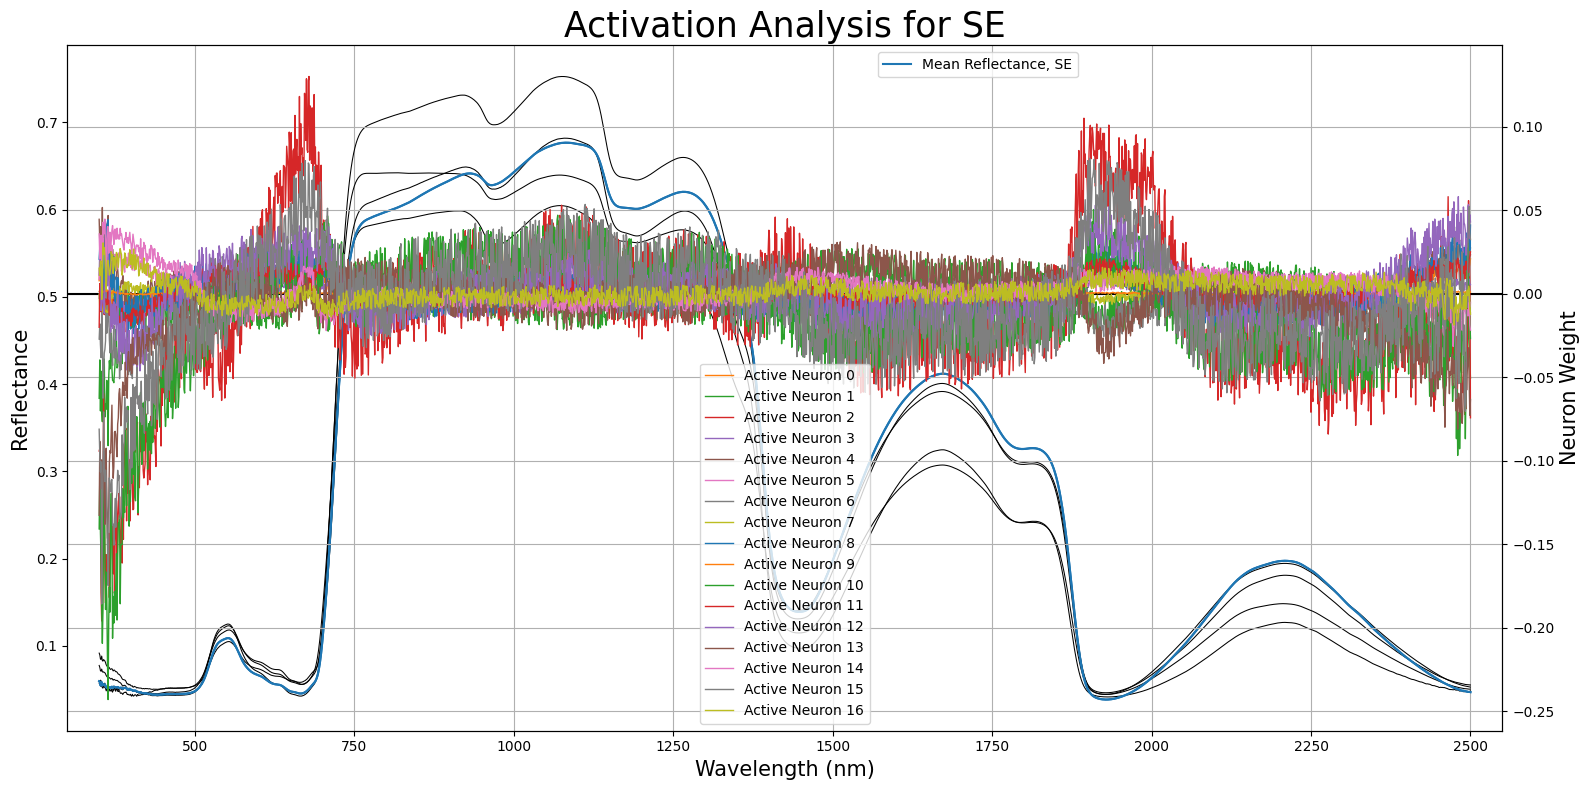

In [21]:
def plot_class_with_activation(class_name):
    
    # Compute the mean spectrum for this class
    class_mean = np.mean(sc.spectra[np.where(Y_type==class_name)[0],:], axis=0)
    # Compute the index in Y_labels for the name of this class
    name_index = np.where(Y_labels==class_name)[0] 
    # Determine the indices for the neurons in the first layer that are active for this class
    neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
    # Determine the amount of activation (weights in second layer) for this class
    neuron_activation = active_weights_2[name_index,neuron_indices]

    c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
    
    fig, ax1 = plt.subplots(figsize=(16,8))
    for class_name in Y_labels:
        class_mean = np.mean(sc.spectra[np.where(Y_type==class_name)[0],:], axis=0)
        ax1.plot(wl,class_mean, color='k', lw=0.75)
    ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
    ax1.set_ylabel('Reflectance', color='k', fontsize=15)
    ax1.plot(wl,class_mean, color=c[0], label=f'Mean Reflectance, {class_name}')
    ax1.tick_params(axis='y', labelcolor='k')
    plt.grid(True, axis='x')
    plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

    ax2 = ax1.twinx()  # second axes, for neruon weights
    ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
    ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=1)
    for i,n_i in enumerate(neuron_indices):
        color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
        ax2.plot(wl, neuron_activation[i]*active_weights_1[n_i,:].flatten(), 
                 color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.grid(True)

    ax1.plot(wl,class_mean, color=c[0])
    plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
    plt.xlim(np.min(wl)-50,np.max(wl)+50)
    plt.legend()
    fig.tight_layout()  
    plt.savefig('output/activation_'+class_name+'.png');
    plt.show()

for class_name in Y_labels:
    plot_class_with_activation(class_name)
    

In [22]:
def normalize_spec(spec, normalize_spectra):
    if normalize_spectra:
        spec = spec/np.max(spec)
    return spec

In [23]:
print(idx)

[80 81 82 83 84 85 86 87 88]


In [24]:
print(Y_labels)

['FL' 'L' 'MX' 'N' 'SE']


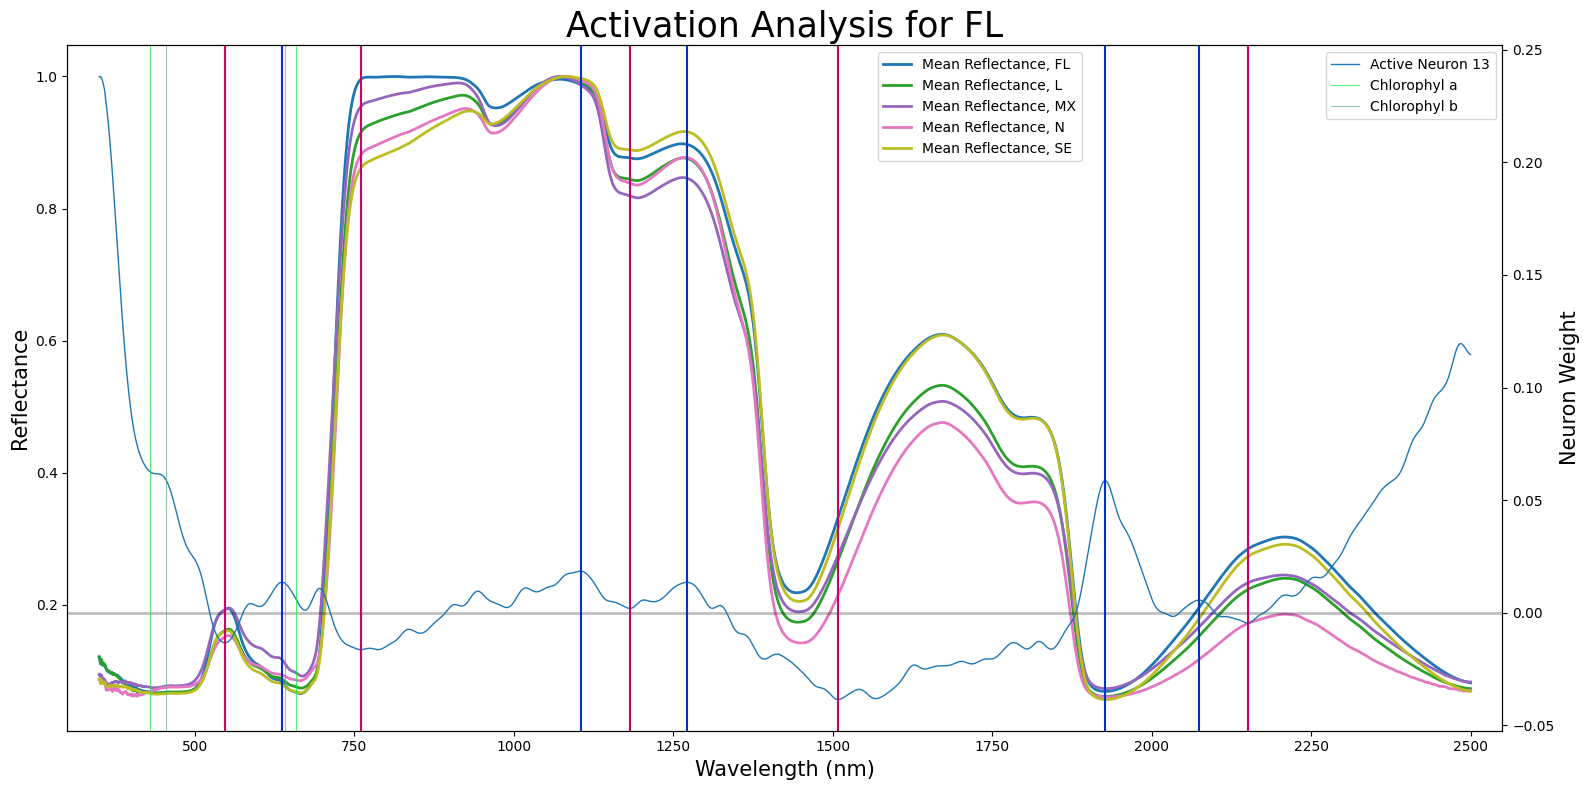

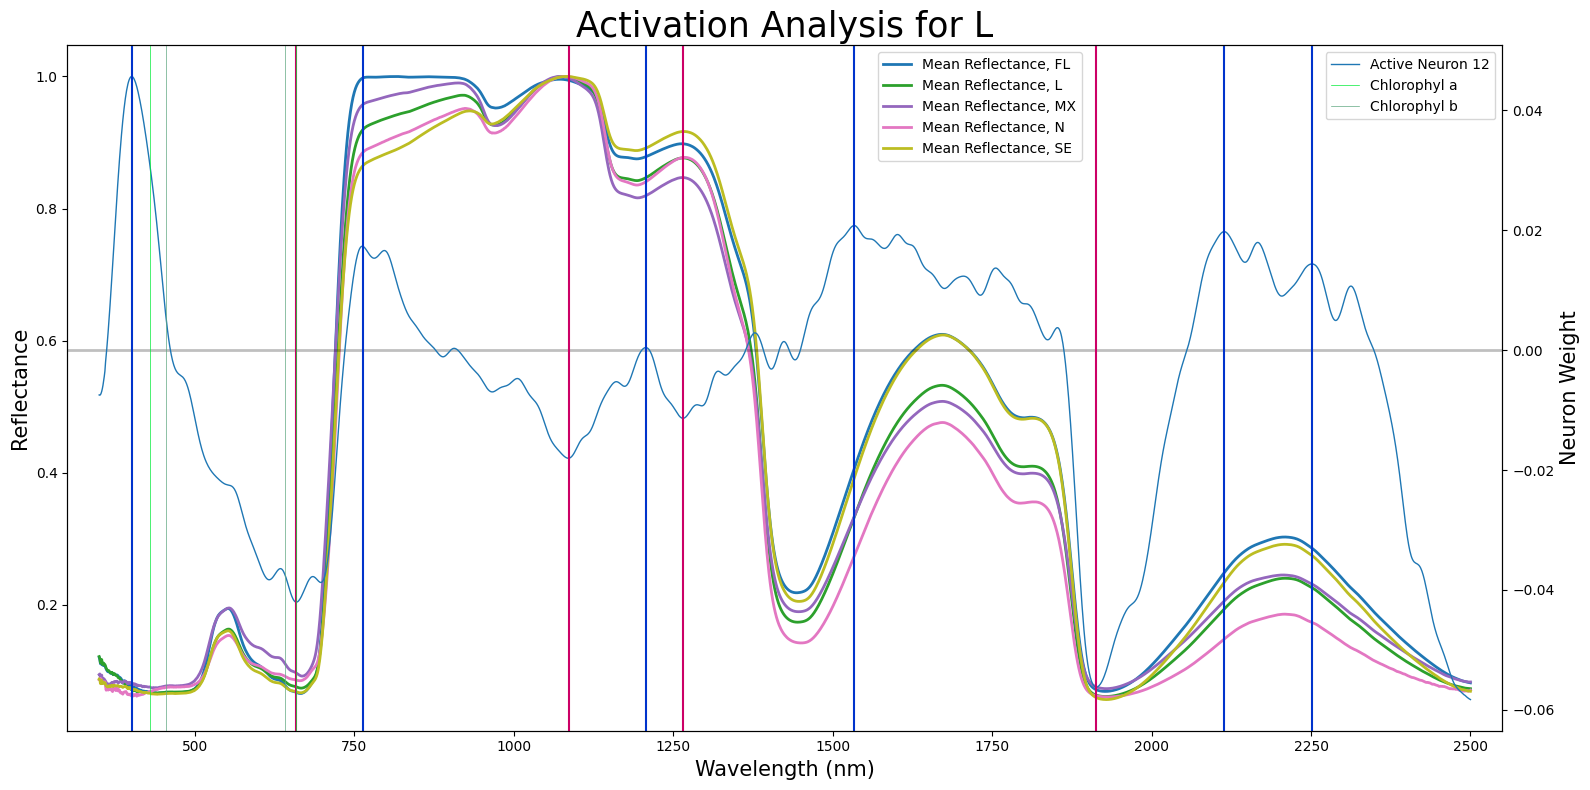

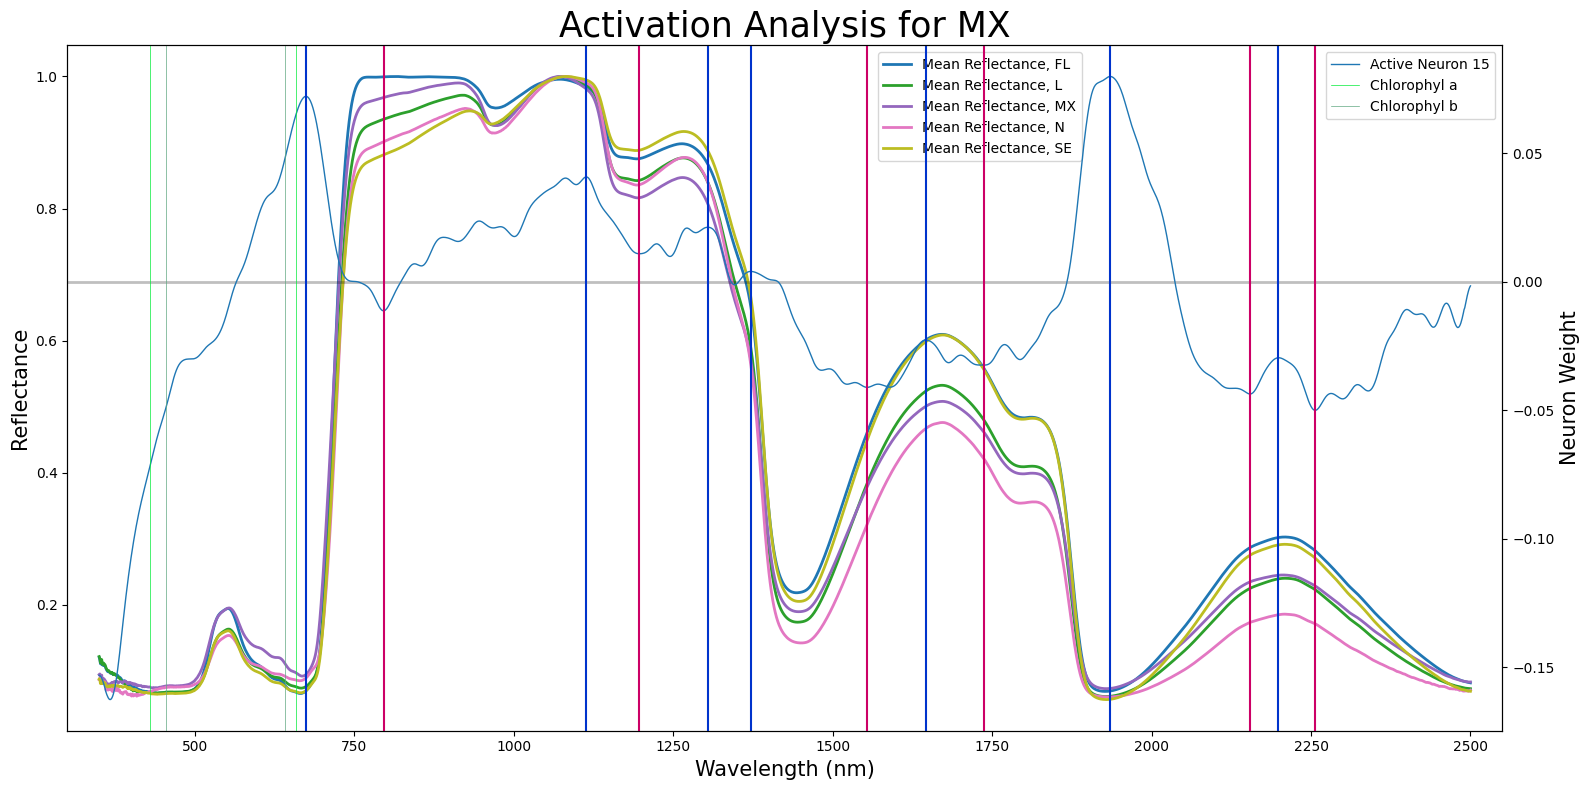

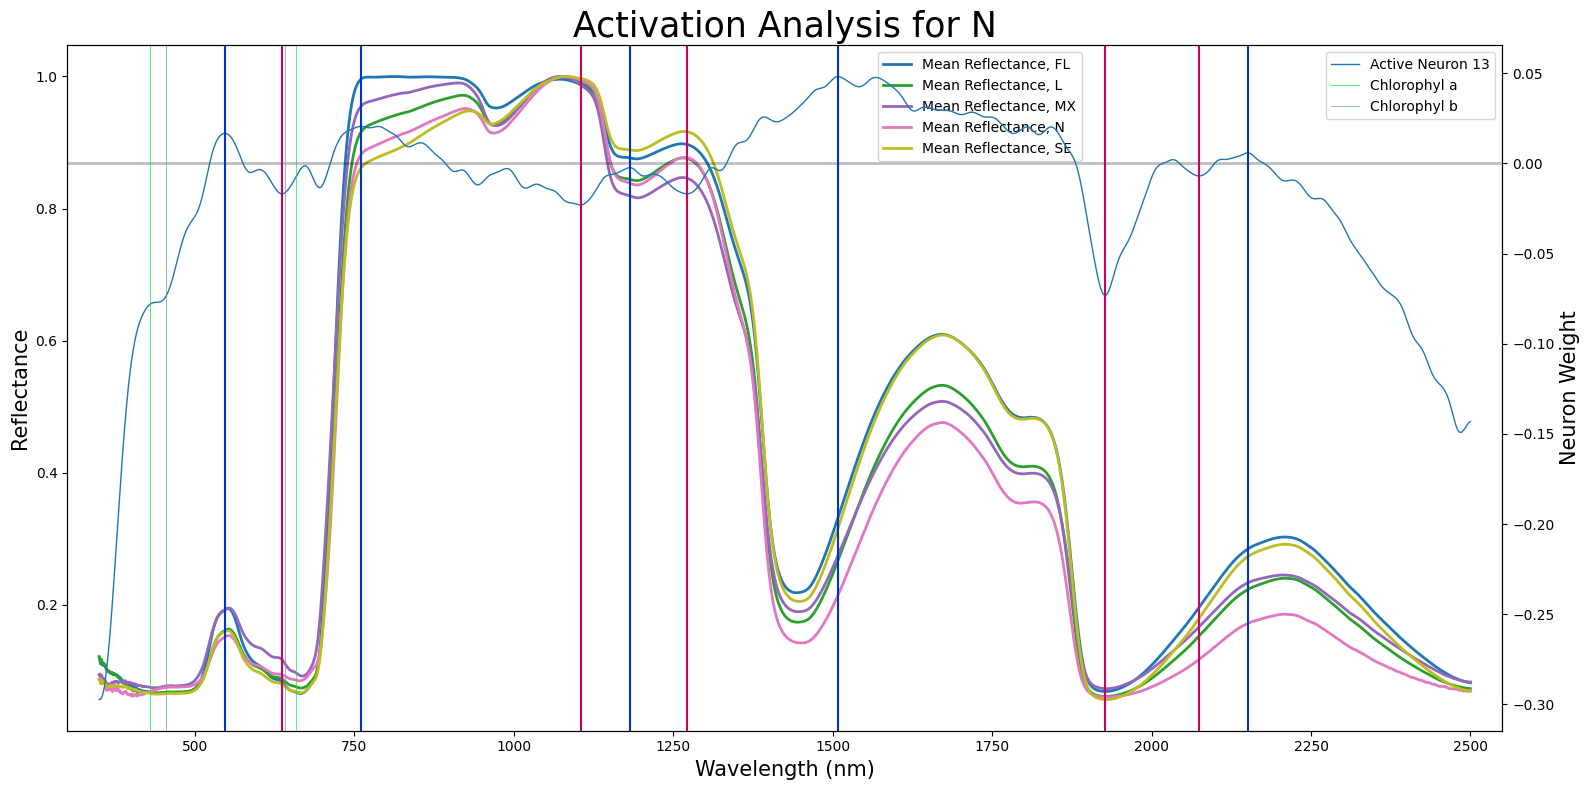

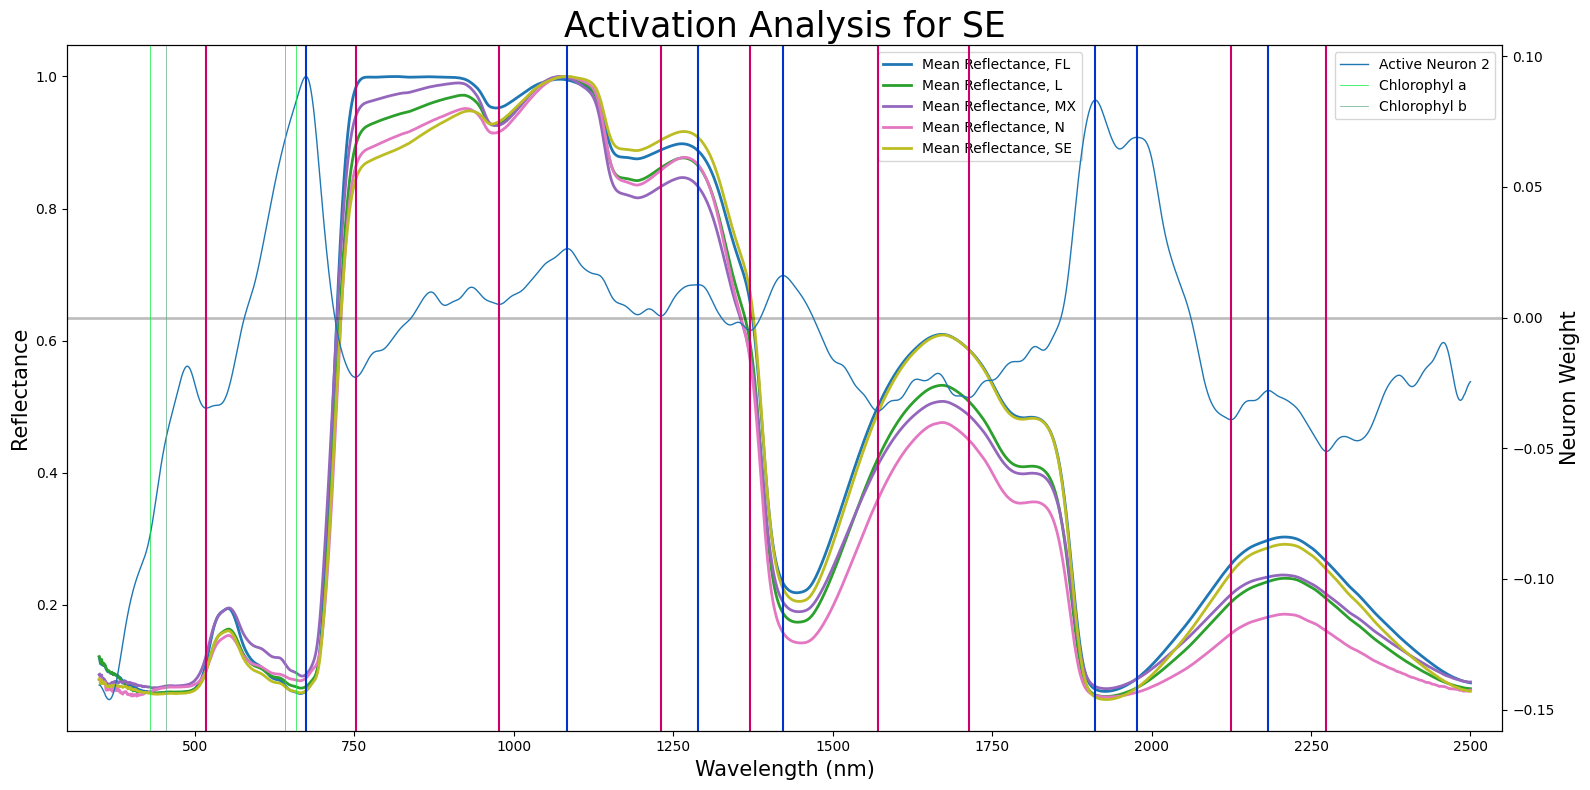

In [25]:
def plot_class_with_activation(max_neurons=4, smooth=True, plot_all_spectra = True, normalize_spectra=True, show_chlorophyl=True, lines_on_peaks=True):
    
    #for idx in [[0,1],[1,0]]:
    for class_name in Y_labels:
        #print(class_name)
        
        # parameters for smoothing the neurons
        sigma = 10
        window = 20
        
        # Compute the mean spectrum for this class
        #class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        
        # Compute the index in Y_labels for the name of this class
        name_index = np.where(Y_labels==class_name)[0] 
        
        #print(name_index)
        
        ##name_index = idx[0]
        ## Determine the indices for the neurons in the first layer that are active for this class
        neuron_indices = np.argsort(-np.abs(active_weights_2[name_index,:].flatten()))
        ##print(neuron_indices)
        ##print(f'unsorted values: {np.abs(active_weights_2[name_index,:].flatten())}')
        
        #for i in neuron_indices:
        #    print(f'index = {i}, value = {np.abs(active_weights_2[name_index,i])}')
        
        # Determine the amount of activation (weights in second layer) for this class
        neuron_activation = active_weights_2[name_index,neuron_indices]

        c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
        
        fig, ax1 = plt.subplots(figsize=(16,8))
        # plot spectra from both classes
        for i, name in enumerate(Y_labels):
            # plot class mean for alternative class

            class_mean = np.mean(spectra[np.where(Y_type==name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), c=cmap(i/len(Y_labels)), lw=2, label=f'Mean Reflectance, {name}')
            # plot each spectra in the alternative class
            if plot_all_spectra:
                for i in np.where(Y_type==name)[0]:
                    ax1.plot(wl, normalize_spec(spectra[i,:], normalize_spectra), lw=0.25, alpha=0.5)
                
        ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
        ax1.set_ylabel('Reflectance', color='k', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='k')
        plt.grid(False)
        plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

        ax2 = ax1.twinx()  # second axes, for neruon weights
        ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
        ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=0.25, lw=2)
        for i,n_i in enumerate(neuron_indices):
            color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
            #print(f"neuron_activation {n_i}: {neuron_activation[i]}")
            neuronACt = neuron_activation[i]*active_weights_1[n_i,:].flatten()
            if smooth:
                neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
            ax2.plot(wl, neuronACt, lw=1, label='Active Neuron '+str(n_i))
            if lines_on_peaks:
                peaks, _ = find_peaks(neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#0033cc')
                peaks, _ = find_peaks(-neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#cc0066')
            if i == max_neurons-1:
                break
        ax2.tick_params(axis='y', labelcolor='k')
        ax2.grid(False)

        # for i, class_name in enumerate(Y_labels):
        #     # plot class mean for alternative class
        #     class_mean = np.mean(spectra[np.where(Y_type==class_name)[0],:], axis=0)
        #     ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), c=cmap(i/len(Y_labels)), lw=2)
        
        plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
        plt.xlim(np.min(wl)-50,np.max(wl)+50)
        
        if show_chlorophyl:            
            # Values from https://rseco.org/content/122-chlorophyll-absorption-and-photosynthetic-action-spectra.html
            plt.axvline(x=429, color='#02eb38', lw=0.5)
            plt.axvline(x=659, color='#02eb38', label='Chlorophyl a', lw=0.5)
            plt.axvline(x=455, color='#60a882', lw=0.5)
            plt.axvline(x=642, color='#60a882', label='Chlorophyl b', lw=0.5)

        
        plt.legend()
        fig.tight_layout()  
        plt.savefig('output/activation_'+class_name+'.png');
        plt.show()

plot_class_with_activation(max_neurons=1, plot_all_spectra = False, smooth=True)

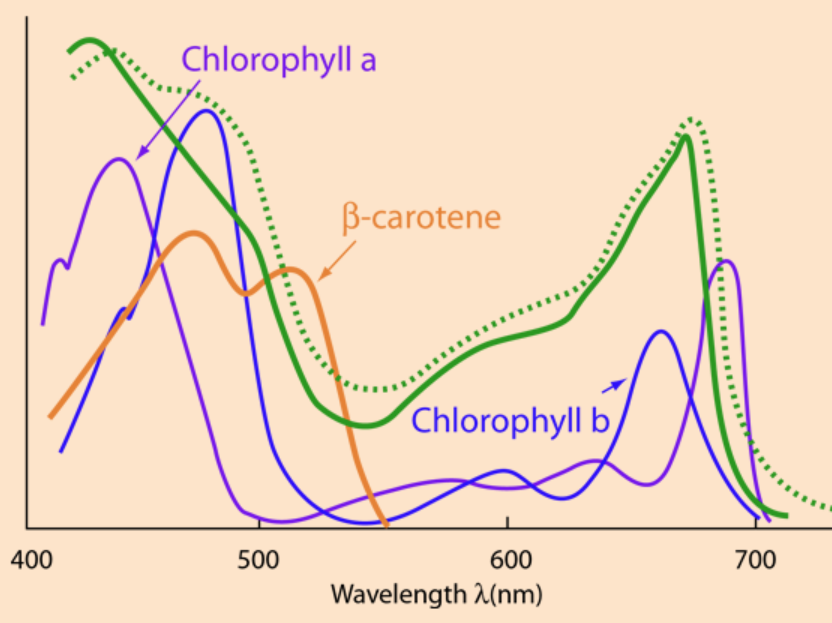

1. Can we convert the neurons to 'features' such as point values and ratios, or something similar that is more understandable?
2. Can we highlight these with lines, boxes, shaded regions?
3. Can we create a metric for each 'feature'?

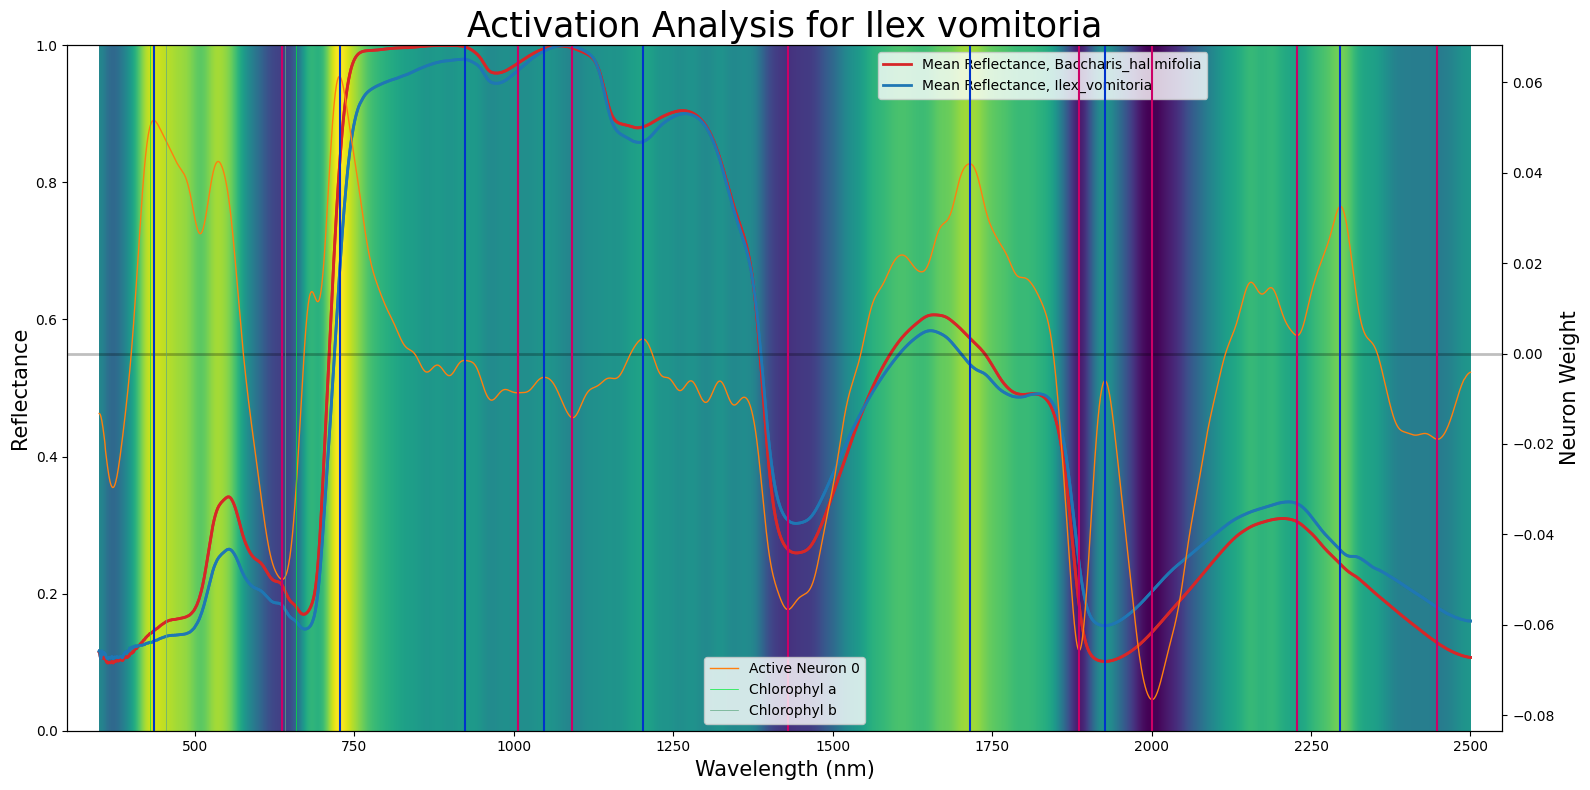

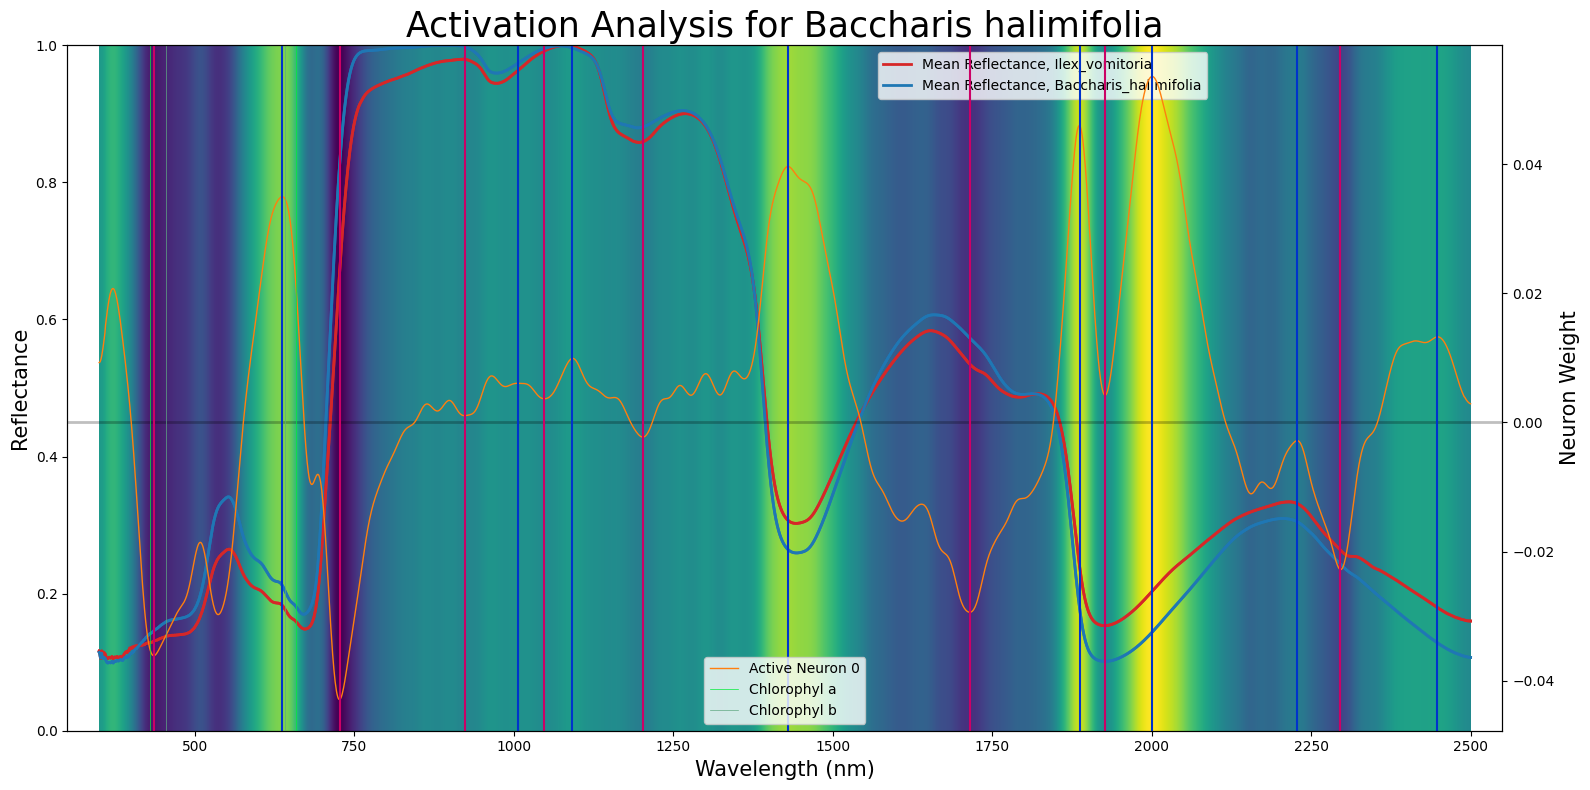

In [46]:
def plot_class_with_activation(max_neurons=4, smooth=True, plot_all_spectra = True, normalize_spectra=True, show_chlorophyl=True, lines_on_peaks=True):
    
    for idx in [[0,1],[1,0]]:
    
        # parameters for smoothing the neurons
        sigma = 10
        window = 20
        
        # Compute the mean spectrum for this class
        #class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        # Compute the index in Y_labels for the name of this class
        #name_index = np.where(Y_labels==class_name)[0] 
        name_index = idx[0]
        # Determine the indices for the neurons in the first layer that are active for this class
        neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
        # Determine the amount of activation (weights in second layer) for this class
        neuron_activation = active_weights_2[name_index,neuron_indices]

        c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
        
        fig, ax1 = plt.subplots(figsize=(16,8))       
        
        # shade background the plot based on the neuron
        neuronACt = neuron_activation[0]*active_weights_1[neuron_indices[0],:].flatten()
        neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
        neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
        neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
        neuronACt = neuronACt-np.min(neuronACt)
        neuronACt = neuronACt/np.max(neuronACt)
        bkrnd = np.zeros((1000,len(wl)))
        for i in range(1000):
            bkrnd[i,:] = neuronACt 
        ax1.imshow(bkrnd, extent=[wl[0], wl[-1], 0, 1], aspect='auto', origin='lower', zorder=-1)
        
        # plot spectra from both classes
        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2, label=f'Mean Reflectance, {class_name}')
            # plot each spectra in the alternative class
            if plot_all_spectra:
                for i in np.where(name==class_name)[0]:
                    ax1.plot(wl, normalize_spec(spectra[i,:], normalize_spectra), color=color, lw=0.25, alpha=0.5)
                
        ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
        ax1.set_ylabel('Reflectance', color='k', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='k')
        plt.grid(False)
        plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

        ax2 = ax1.twinx()  # second axes, for neruon weights
        ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
        ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=0.25, lw=2)
        for i,n_i in enumerate(neuron_indices):
            color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
            neuronACt = neuron_activation[i]*active_weights_1[n_i,:].flatten()
            if smooth:
                neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
            ax2.plot(wl, neuronACt, color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
            if lines_on_peaks:
                peaks, _ = find_peaks(neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#0033cc')
                peaks, _ = find_peaks(-neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#cc0066')
            if i == max_neurons-1:
                break
        
        ax2.tick_params(axis='y', labelcolor='k')
        ax2.grid(False)

        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2)
        plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
        plt.xlim(np.min(wl)-50,np.max(wl)+50)
        
        if show_chlorophyl:            
            # Values from https://rseco.org/content/122-chlorophyll-absorption-and-photosynthetic-action-spectra.html
            plt.axvline(x=429, color='#02eb38', lw=0.5)
            plt.axvline(x=659, color='#02eb38', label='Chlorophyl a', lw=0.5)
            plt.axvline(x=455, color='#60a882', lw=0.5)
            plt.axvline(x=642, color='#60a882', label='Chlorophyl b', lw=0.5)
 
        
        plt.legend()
        fig.tight_layout()  
        plt.savefig('output/activation_'+class_name+'.png');
        plt.show()
        
        #plt.figure()
        #plt.imshow(bkrnd)

plot_class_with_activation(max_neurons=1, plot_all_spectra = False, smooth=True)

In [30]:
bkrnd = np.zeros((1000,len(wl)))
for i in range(1000):
    bkrnd[i,:] = neuronACt

NameError: name 'neuronACt' is not defined

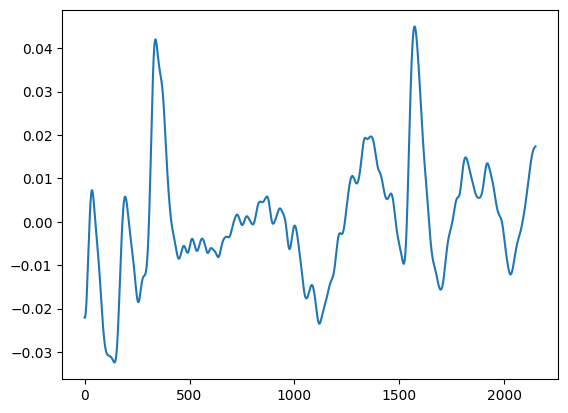

In [151]:
plt.plot(neuronACt)

In [152]:
plt

<module 'matplotlib.pyplot' from 'c:\\Users\\wb8by\\Documents\\GitHub\\NN_Hyperspectral_Vegetation\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>